In [43]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format',lambda x:'%.3f' % x)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')
import os, sys
import warnings
warnings.filterwarnings('ignore')

# set random seed to reproducibility
np.random.seed(9397)

# 1.Original Data import

In [3]:
# set the path of dataset
data_path = os.path.join(os.getcwd(),'data')

### merge the training and testing set
# T1 = pd.read_excel(os.path.join(data_path, "LendingClubData_training.xlsx"))
# T2 = pd.read_excel(os.path.join(data_path, "LendingClubData_testing.xlsx"))
# data = pd.concat([T1,T2])
# data = data.reset_index(drop = True)
# data.to_csv(os.path.join(data_path,"LendingClubData_original.csv"),index = False)
data = pd.read_csv(os.path.join(data_path, "LendingClubData_original.csv"))

# 2.data preprocessing
## 2.1 Missing values - feature level

In [5]:
# data preprocessing
print("Original data: LendingClubData_original.csv")
print(f"Shape of DataFrame: {data.shape}")

Original data: LendingClubData_original.csv
Shape of DataFrame: (39786, 145)


In [10]:
missing = data.isnull().sum()/data.shape[0]
missing.reset_index().rename(columns={'index':'col',0 :'missing_pct'})

,col,missing_pct
0,id,1.000
1,member_id,1.000
2,loan_amnt,0.000
3,funded_amnt,0.000
4,funded_amnt_inv,0.000
...,...,...
140,settlement_status,0.996
141,settlement_date,0.996
142,settlement_amount,0.996
143,settlement_percentage,0.996


In [12]:
# calculate missing rate of variables
def cal_missing(df):
    missing = df.isnull().sum()/df.shape[0]
    missing = missing.reset_index().rename(columns={'index':'col',0 :'missing_pct'})
    # sort the features by missing ratio
    missing = missing.sort_values('missing_pct',ascending = False).reset_index(drop=True)
    return missing

# distribution of missing rate
def plot_missing_distribution(df, plt_size = (8,6)):
    missing = cal_missing(df)
    
    # plot the distribution of missing percentage 
    plt.figure(figsize = plt_size)
    plt.rcParams['axes.unicode_minus'] = False
    x = missing['missing_pct']
    plt.hist(x=x,bins=np.arange(0,1.1,0.1),color='red',ec='k',alpha=0.9)
    plt.ylabel('Number of missing variables')
    plt.xlabel('Missing rate')
    return plt.show()

# delete variables whose portion of missing value are greater than the threshold
def delete_missing_variable(df,threshold = 1):
    df2 = df.copy()
    missing = cal_missing(df)
    missing_col = (missing[missing["missing_pct"] >= threshold])['col']
    df2 = df2.drop(missing_col, axis=1)
    return df2

# delete constant variable
def delete_const_variable(df, threshold = 1):
    df2 = df.copy()
    const_col = []
    for col in df.columns:
        pct = df[col].value_counts().iloc[0]/df[col].notnull().sum()
        if pct >= threshold:
            const_col.append(col)
    df2 = df2.drop(const_col,axis=1)
    return df2


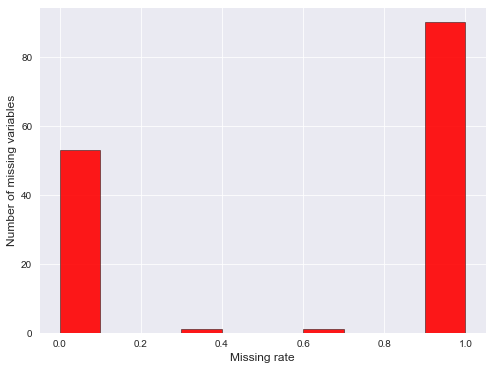

Original number of features: 145
Number of features after delete variables have missing more than 0.4: 54
Number of features after delete constant variables where one value takes more than 0.9 : 36


In [13]:
plot_missing_distribution(data)
print("Original number of features: \033[1m{}\033[0m".format(data.shape[1]))
missing_threshold = 0.4
df = delete_missing_variable(data,threshold = missing_threshold)
print("Number of features after delete variables have missing more than \033[1m{}\033[0m: \033[1m{}\033[0m".format(missing_threshold, df.shape[1]))
constant_threshold = 0.9
df = delete_const_variable(df,threshold = constant_threshold)
print("Number of features after delete constant variables where one value takes more than \033[1m{}\033[0m : \033[1m{}\033[0m".format(constant_threshold, df.shape[1]))

## 2.2 Missing values - record level

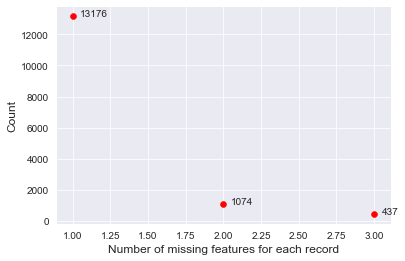

Shape of DataFrame: (39786, 36)


In [20]:
# delete records which have missing observations
record_missing_status = df.isnull().sum(axis=1)
missing_feature_amount = np.arange(1,np.max(record_missing_status))
count_of_missing_record = [sum(record_missing_status == k) for k in missing_feature_amount ]

# plot 
plt.figure()
plt.scatter(missing_feature_amount,count_of_missing_record,color = "red")
plt.ylabel('Count')
plt.xlabel('Number of missing features for each record')
for i in range(len(missing_feature_amount)):
    plt.text(missing_feature_amount[i]+0.05,
             count_of_missing_record[i],
             count_of_missing_record[i],
             #bbox=dict(facecolor='red', alpha=0.5)
            )
    
plt.show()
###
print(f"Shape of DataFrame: {df.shape}")

## 2.3 Fill missing value & Feature Transformation

In [24]:
def value_count(df,colname):
    return df[colname].value_counts()
def plot_count_distribution(df, colname, figsize = (8,6),fontsize = 15,position = 5,percentage = False):
    fig, ax= plt.subplots(figsize = figsize)
    sns.set_style('whitegrid')
    sns.set_context('notebook')
    ax = sns.countplot(x=colname,data = df)
    # add acnnotation
    if not percentage:        
        for p in ax.patches:
            value = p.get_height()
            height, width =p.get_height(), p.get_width()
            x=p.get_x()+width * (position/10)
            y=p.get_y()+height+0.08
            ax.annotate(value,(x,y),fontsize = fontsize)
    else:
        total = len(df[colname])
        for p in ax.patches:
            value = '{:.2f}%'.format(100 * p.get_height()/total)
            height, width =p.get_height(), p.get_width()
            x=p.get_x()+width * (position/10)
            y=p.get_y()+height+0.08
            ax.annotate(value,(x,y),fontsize = fontsize)
    

    plt.title(f"Countplot -- {colname}",size=20)
    plt.ylabel("count",size = 15)
    plt.xlabel(colname,size = 15)
    plt.xticks(fontsize =13)
    plt.yticks(rotation =50,fontsize =13)
    plt.show()
    plt.close(fig)
    return plt.show()

In [23]:
numerical = []
categorical = []
for i in df.columns:
    if df.dtypes[i] == 'int64' or df.dtypes[i] == 'float64':
        numerical.append(i)
    else:
        categorical.append(i)
print("Numerical: {}\n".format(numerical))
print("Categorical: {}".format(categorical))
# selected_feature

features = {
    "term": 1 ,# numerical,
    "emp_length": 2 ,# label encoding,
    "home_ownership": 2, # label encoding
    "verification_status": 2, # label encoding,
}


Numerical: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'recoveries', 'last_pymnt_amnt']

Categorical: ['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']


In [25]:
# columns which contain missing value
df.isnull().sum()[df.isnull().any()]

emp_title              2467
emp_length             1078
desc                  12967
title                    12
revol_util               50
last_pymnt_d             71
last_credit_pull_d        2
dtype: int64

In [26]:
df_new = pd.DataFrame()
# responseT
df_new["loan_status"] = df["loan_status"] #.map({"Fully Paid":0, "Charged Off":1})
df_new["loan_status"] = df["loan_status"].map({"Fully Paid":"Fully Paid", "Charged Off":"charged Off"})
# term : The number of payments on the loan. Values are in months and can be either 36 or 60.
df_new["term"] = df["term"].map({" 36 months":36, " 60 months":60})

# home_ownership: The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER
df_new["home_ownership"] = df["home_ownership"].map({"NONE":1,"OTHER":1,"RENT":2,"MORTGAGE":3,"OWN":4})

# emp_length : Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
df["emp_length"].fillna(0,inplace=True)
df_new["emp_length"]= np.where(df["emp_length"]== "10+ years", 10,
                           np.where(df["emp_length"] == "1 year", 1,
                                   np.where(df["emp_length"] == "2 years", 2,
                                           np.where(df["emp_length"] == "3 years", 3,
                                                   np.where(df["emp_length"] == "4 years", 4,
                                                           np.where(df["emp_length"] == "5 years", 5,
                                                                   np.where(df["emp_length"] == "6 years", 6,
                                                                            np.where(df["emp_length"] == "7 years", 7,
                                                                                     np.where(df["emp_length"] == "8 years", 8,
                                                                                              np.where(df["emp_length"] == "9 years", 9, 0))))))))))
# verification_status: Indicates if income was verified by LC, not verified, or if the income source was verified
df_new["verification_status"] = df["verification_status"].map({"Not Verified":1,"Verified":2,"Source Verified":3})


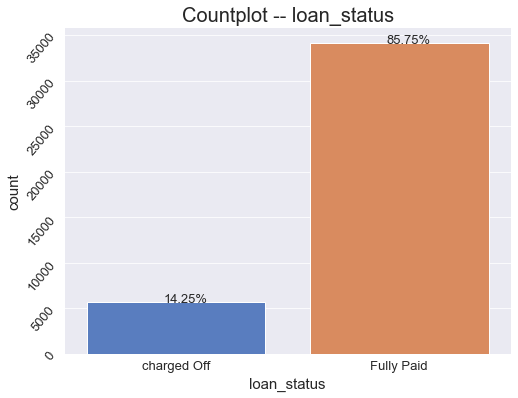

In [27]:
# unbalanced data
plot_count_distribution(df_new, "loan_status",fontsize = 13,position = 4.3,percentage = True)

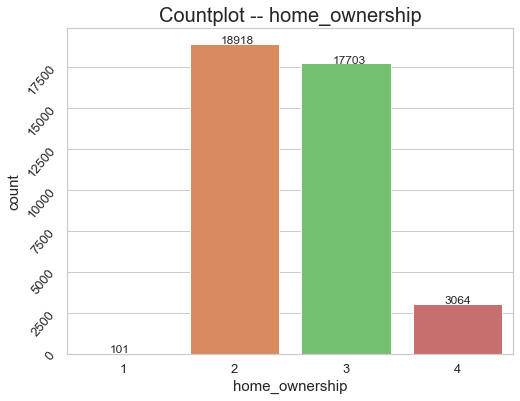

In [28]:
plot_count_distribution(df_new, "home_ownership",fontsize = 12,position=3.5)

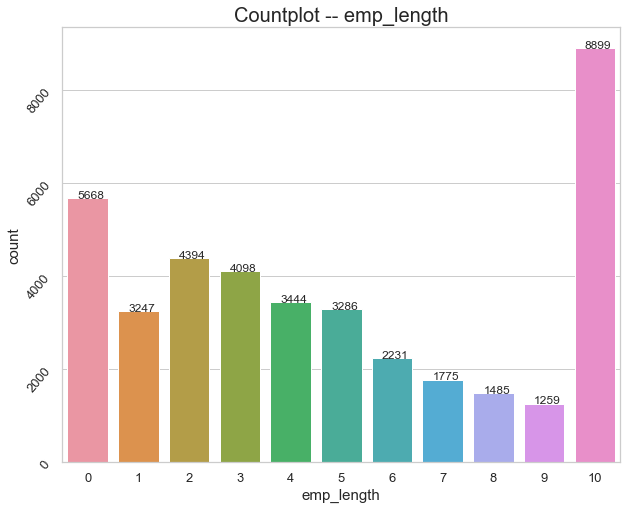

In [29]:
plot_count_distribution(df_new, "emp_length",figsize = (10,8), fontsize = 12,position=2.5)

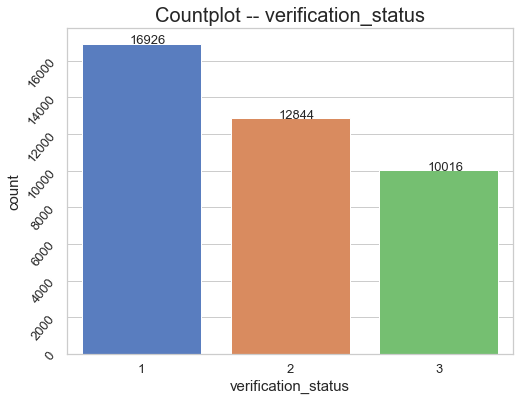

In [30]:
plot_count_distribution(df_new, "verification_status",fontsize = 13,position = 4)

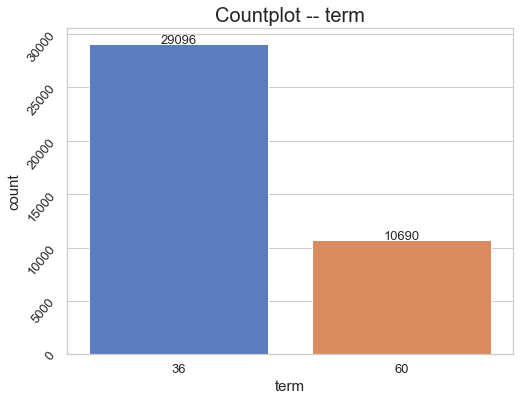

In [31]:
plot_count_distribution(df_new, "term",fontsize = 13,position = 4)

In [35]:
#### numerical features

# installment: The monthly payment owed by the borrower if the loan originates.
df_new["installment"] = df["installment"]

# annual_inc: The self-reported annual income provided by the borrower during registration.
df_new["monthly_inc"] = df["annual_inc"]/12
df_new["PaymentToIncome"] = df["installment"]/df_new["monthly_inc"]

# dti : A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
df_new["dti"] = df["dti"]

# delinq_2yrs : The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
df_new["delinq_2yrs"] = df["delinq_2yrs"]

# inq_last_6mths : The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
df_new["inq_last_6mths"] = df["inq_last_6mths"]

# open_acc : The number of open credit lines in the borrower's credit file.
df_new["open_acc"] = df["open_acc"]


# revol_bal : Total credit revolving balance
df_new["revol_bal"] = df["revol_bal"]

# revol_util : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
df_new["revol_util"] = df["revol_util"].fillna(method = "ffill")

# total_acc : The total number of credit lines currently in the borrower's credit file
df_new['total_acc'] = df["total_acc"]


In [30]:
df_new.head(10)

,loan_status,term,home_ownership,emp_length,verification_status,installment,monthly_inc,PaymentToIncome,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,charged Off,60,3,10,2,773.440,9166.667,0.084,1.060,0,0,10,0,4142,0.064,27
1,Fully Paid,36,2,10,2,327.700,4500.000,0.073,17.690,0,1,6,0,5460,0.853,11
2,charged Off,36,3,0,3,118.230,3916.667,0.030,22.520,0,3,10,0,8100,0.393,41
3,charged Off,60,4,9,3,342.900,5417.000,0.063,6.260,0,3,11,0,8990,0.775,21
4,charged Off,60,2,4,3,100.000,3750.000,0.027,7.370,0,0,10,0,4786,0.825,13
5,Fully Paid,36,2,1,3,228.270,17500.000,0.013,3.700,0,0,10,0,15610,0.358,19
6,Fully Paid,36,2,10,1,373.330,10000.000,0.037,6.440,0,2,7,0,21702,0.582,27
7,Fully Paid,60,2,10,2,397.770,4916.667,0.081,18.650,0,0,11,0,30583,0.487,31
8,charged Off,36,3,6,2,289.090,3333.333,0.087,11.310,0,0,6,0,7583,0.689,16
9,Fully Paid,60,2,10,2,728.910,11250.000,0.065,2.610,0,1,11,0,9343,0.274,31


# 3. Train and Test split

In [38]:
# from sklearn.model_selection import train_test_split
# X = df_new["loan_status"]
# Y = df_new.iloc[:,1:]
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=9397)


train = df_new.sample(frac=0.8,random_state=9397)
test = df_new.iloc[df_new.index.drop(train.index), :]
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [39]:
train.to_csv(os.path.join(data_path, "train.csv"),index = False)
test.to_csv(os.path.join(data_path, "test.csv"), index = False)

# 4.Resample to solve unbalanced data problem

In [40]:
# Synthetic Minority Over-sampling Technique
from collections import Counter
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import TomekLinks
print('Original dataset shape %s' % Counter(train["loan_status"]))

# Under sampling TomekLinks
undersample = TomekLinks()
x, y = undersample.fit_resample(train.iloc[:,1:].values,train["loan_status"].values)
print('Tomek Links : Resampled dataset shape %s' % Counter(y))

# Using smoteNC to deal with categorical features(KNN)
smt = SMOTENC(categorical_features=[i for i in range(4)],random_state=42)
x, y = smt.fit_resample(x,y)
print('SMOTE : Resampled dataset shape %s' % Counter(y))
x = pd.DataFrame(x,columns=train.columns[1:])
y = pd.DataFrame(y,columns=train.columns[:1])
train_smt = pd.merge(y,x,left_index = True,right_index=True)


Original dataset shape Counter({'Fully Paid': 27260, 'charged Off': 4569})
Tomek Links : Resampled dataset shape Counter({'Fully Paid': 25127, 'charged Off': 4569})
SMOTE : Resampled dataset shape Counter({'Fully Paid': 25127, 'charged Off': 25127})


In [41]:
train_smt.to_csv(os.path.join(data_path, "train_resample.csv"),index = False)

In [42]:
train_smt

,loan_status,term,home_ownership,emp_length,verification_status,installment,monthly_inc,PaymentToIncome,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc
0,Fully Paid,60.000,2.000,4.000,3.000,388.670,4333.000,0.090,16.430,0.000,0.000,7.000,2644.000,0.482,15.000
1,Fully Paid,36.000,2.000,0.000,1.000,38.510,1600.000,0.024,10.190,0.000,0.000,9.000,6283.000,0.472,10.000
2,Fully Paid,36.000,2.000,7.000,1.000,221.280,4666.667,0.047,9.110,0.000,1.000,13.000,977.000,0.027,32.000
3,Fully Paid,36.000,3.000,0.000,3.000,167.090,4166.667,0.040,15.840,0.000,1.000,7.000,14576.000,0.684,18.000
4,Fully Paid,36.000,3.000,9.000,1.000,372.120,5000.000,0.074,16.320,1.000,0.000,9.000,13703.000,0.322,37.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50249,charged Off,60.000,2.000,5.000,1.000,137.352,4446.252,0.031,7.268,0.000,1.967,10.257,2475.432,0.303,20.967
50250,charged Off,60.000,3.000,3.000,2.000,256.988,8368.699,0.031,11.523,0.433,0.866,9.433,14700.970,0.689,27.496
50251,charged Off,60.000,2.000,10.000,2.000,161.380,5000.000,0.032,20.832,0.000,2.911,9.179,7973.249,0.429,30.927
50252,charged Off,36.000,2.000,0.000,3.000,157.957,2082.847,0.076,3.814,0.000,0.004,2.004,4800.985,0.565,7.018
